<a href="https://colab.research.google.com/github/MohdYasser1/End-to-End-Deep-Learning-Self-Driving-Car/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Behaviour Clonning for Self-Driving Car simulator using Deep Learning  
This NoteBook is about using deep-learning to take images captured by a simulator that is driven by myself. The goal of this project is to try several famous deep-learning architecture as well as trying one by self.
### The content of this NoteBook will include:
1. Self-Made architecture
2. Nvidea's architecture for Self-Driving cars (Comming Soon ...)
3. An upgrade for the Nvidea's architecture using Feature Analysis and Selection (Comming Soon ...)
4. End-to-End Learning with Memory Models (Comming Soon ...)

### 1. Self-Made Architecture  
We will first start with an architecture made from my knowledge of CNN and using random hyperparamters and random layers (Everything will be random 😂). This architecture will be the base architecture to evaluate the next famous architectures.

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import Numpy for data manuplation
import numpy as np
import pandas as pd

# Import Pytorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, ConcatDataset, random_split, DataLoader

# Import torchvision
from torchvision import transforms, datasets

#Import PIL.Image
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

The Data collected are seperated into 2 Dataset:  
1. A dataset driving the track normally.
2. A dataset driving the track the other way

We first need to make a custom Dataset to get the images with the labels

In [56]:
class CustomDataSet(Dataset):
    def __init__(self, csv_file, transform = None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        images = Image.open(self.df.iloc[idx, 0])

        if self.transform:
            images =self.transform(images)

        steering_angle = self.df.iloc[idx, 3:4].values.astype(float)
        throttle = self.df.iloc[idx, 4:5].values.astype(float)

        return images, steering_angle, throttle

In [57]:
# Inputting image details
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 160, 320, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

#Defining image transformations
data_transform = transforms.Compose([transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
                                    transforms.ToTensor()])

In [58]:
# Loading csvs files
forward_csv_path = r"/content/drive/MyDrive/Data/RacingTeam/DeepLearning Project/Forward/driving_log.csv"
backward_csv_path = r"/content/drive/MyDrive/Data/RacingTeam/DeepLearning Project/Backward/driving_log.csv"

# Create the DataSets
froward_data = CustomDataSet(forward_csv_path, data_transform)
backward_data = CustomDataSet(backward_csv_path, data_transform)

# Joining the 2 Datasets
data = ConcatDataset([froward_data, backward_data])

#Checking the data
print(f"The size of the whole datase: {len(data)}\n")

# Splitting the data into train and test
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = random_split(data, [train_size, test_size])
print(f"The size of the train data: {len(train_data)}")
print(f"The size of the test data: {len(test_data)}")

The size of the whole datase: 6633

The size of the train data: 5306
The size of the test data: 1327


In [59]:
# Creating the DataLoaders
train_loader = DataLoader(train_data, batch_size = 40, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 40, shuffle = False)


This architecture will be based on a simple architecture I took in the Deep Learning Session.  
The Architecture will be consisted of:
1. Convlution Layer 48@78x158 + Maxpooling 48@39x79
2. Convlution Layer 96@18x38 + Maxpooling 96@9x19
3. Flatten
4. Fully-connected layer with 50 neuros
5. Fully-connected layer with 10 neurons
6. Output-Layer with 2 outputs: Steering_angle & Throttle

In [60]:
# Creating the CNN model
import torch.nn.functional as F

class SelfMadeModel(nn.Module):
    def __init__(self):
        super(SelfMadeModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=48,
                kernel_size=5,
                stride=(2,2),
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(48, 96, 5, (2,2)),
            nn.ReLU(),
            nn.MaxPool2d(2),

        )
        self.fc = nn.Linear(9*19*96, 25)
        self.fc1 = nn.Linear(25, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 16416)
        x = F.relu(self.fc(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [61]:
model = SelfMadeModel().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.005)
model

SelfMadeModel(
  (conv1): Sequential(
    (0): Conv2d(3, 48, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(48, 96, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=16416, out_features=25, bias=True)
  (fc1): Linear(in_features=25, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=2, bias=True)
)

In [37]:
# Trying the model
examples = iter(test_loader)
example_data = next(examples)
images = example_data[0][0].to(device)
dummy_input = torch.randn(3, 160, 320).to(device)
print(dummy_input.shape)
output = model(dummy_input)
print(output)
loss = loss_fn(output, torch.tensor((-0.5, 1.0)).to(device))
print(loss)

torch.Size([3, 160, 320])
tensor([[-0.1628, -0.0431]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(0.6009, device='cuda:0', grad_fn=<MseLossBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [62]:
# Training the model

num_epochs = 10

def train(num_epoches, model, loss_fn, optimizer, loader):

    model.train()

    total_step = len(loader)

    for epochs in range(num_epoches):
        model.train()
        running_loss = 0.0
        for i, (images, steering_angle, throttle) in enumerate (loader):

            images = images.to(device)
            steering_angle = steering_angle.to(device)
            throttle = throttle.to(device)


            outputs = model(images)
#             print(outputs)
#             print([steering_angle, throttle])
            loss = loss_fn(outputs, torch.cat((steering_angle, throttle), dim=1).to(torch.float32))

#             print(output.dtype)
#             print(torch.cat((steering_angle, throttle), dim=1).to(torch.float32).dtype)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        print(f'[{epochs + 1}] loss: {running_loss / total_step:.3f}')
    print('Finished Training')


In [39]:
train(10 , model, loss_fn, optimizer, train_loader)

[1] loss: 0.588
[2] loss: 0.028
[3] loss: 0.027
[4] loss: 0.027
[5] loss: 0.026
[6] loss: 0.026
[7] loss: 0.025
[8] loss: 0.025
[9] loss: 0.024
[10] loss: 0.022
Finished Training


In [40]:
from IPython.display import clear_output
# Evaluate the model
model.eval()

running_loss = 0.0
num_of_batches = 0.0

with torch.no_grad():
  n_samples = len(test_loader.dataset)

  for i, (images, steering_angle, throttle) in enumerate (test_loader):

    images = images.to(device)
    steering_angle = steering_angle.to(device)
    throttle = throttle.to(device)

    preds = model(images)
    loss = loss_fn(preds, torch.cat((steering_angle, throttle), dim=1).to(torch.float32))
    running_loss += loss.item()
    num_of_batches +=1
    clear_output(wait=True)
    print(f'{i+1} / {len(test_loader)}')
print(running_loss/num_of_batches)

34 / 34
0.026414296535008094


In [41]:
print([preds, torch.cat((steering_angle, throttle), dim=1).to(torch.float32)])

[tensor([[ 0.1312,  1.0033],
        [ 0.0257,  0.9975],
        [ 0.0129,  1.0196],
        [ 0.0246,  1.0465],
        [ 0.0620,  1.0475],
        [-0.0583,  1.0413],
        [-0.1045,  0.9877]], device='cuda:0'), tensor([[0.3500, 1.0000],
        [0.0000, 1.0000],
        [0.0000, 1.0000],
        [0.0000, 1.0000],
        [0.0000, 1.0000],
        [0.0000, 1.0000],
        [0.0000, 1.0000]], device='cuda:0')]


In [42]:
torch.save(model, "model.pth")

In [63]:
from matplotlib import pyplot as plt

steer=[]

for _,y,_ in train_loader:
  for k in range(len(y)):
    steer.append(y[k])
# plt.hist(np.array(steer), density = True, weights=np.ones(len(steer)) / len(steer) * 100)
# plt.show

In [64]:
np.count_nonzero(np.array(steer) == 0)/len(steer)

<ipython-input-64-6023729e997e>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.count_nonzero(np.array(steer) == 0)/len(steer)
<ipython-input-64-6023729e997e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.count_nonzero(np.array(steer) == 0)/len(steer)


0.8077647945721824

<function matplotlib.pyplot.show(close=None, block=None)>

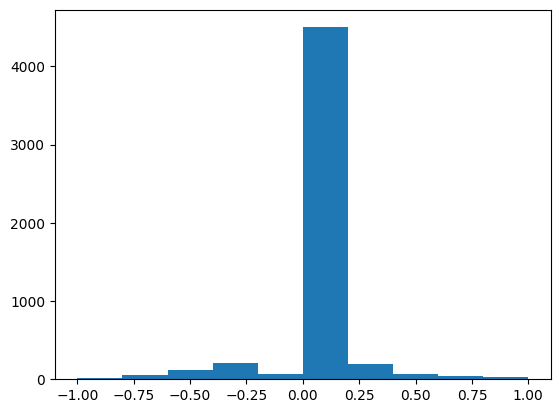

In [65]:
steer = [tensor.item() for tensor in steer]

plt.hist(np.array(steer))
plt.show


Almost 80% of the train data has a steering angle of 0.

We will try to fix it by getting only 25% of the data that has a value of 0

In [66]:
zero_angle_data = [sample for sample in train_loader.dataset if sample[1][0] == 0]
non_zero_angle_data = [sample for sample in train_loader.dataset if sample[1][0] != 0]
sample_size = int(0.25 * len(zero_angle_data))
sampled_data = torch.utils.data.RandomSampler(zero_angle_data, num_samples=sample_size)

#Create a dataset from the random sampler
sampled_indices = list(sampled_data)
sampled_dataset = [train_loader.dataset[i] for i in sampled_indices]

processed_train = ConcatDataset([sampled_dataset, non_zero_angle_data])
new_train_loader = DataLoader(processed_train, batch_size=40, shuffle=True)
# len(new_train_loader)

In [67]:
len(new_train_loader.dataset)

2091

In [68]:
steer=[]

for _,y,_ in new_train_loader:
  for k in range(len(y)):
    steer.append(y[k])
# plt.hist(np.array(steer), density = True, weights=np.ones(len(steer)) / len(steer) * 100)
# plt.show
np.count_nonzero(np.array(steer) == 0)/len(steer)

<ipython-input-68-1af6d36fd842>:8: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.count_nonzero(np.array(steer) == 0)/len(steer)
<ipython-input-68-1af6d36fd842>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.count_nonzero(np.array(steer) == 0)/len(steer)


0.4146341463414634

<function matplotlib.pyplot.show(close=None, block=None)>

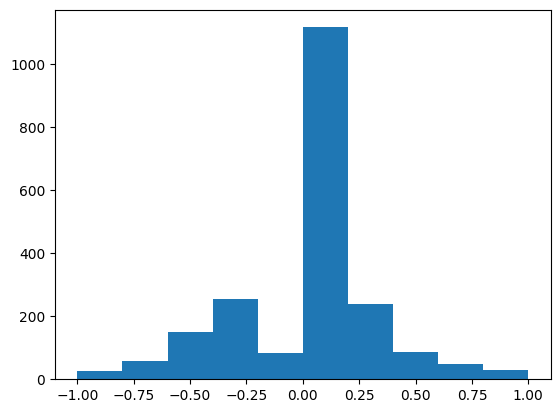

In [69]:
steer = [tensor.item() for tensor in steer]

plt.hist(np.array(steer))
plt.show


In [74]:
train(30 , model, loss_fn, optimizer, new_train_loader)

[1] loss: 0.066
[2] loss: 0.066
[3] loss: 0.066
[4] loss: 0.067
[5] loss: 0.066
[6] loss: 0.066
[7] loss: 0.068
[8] loss: 0.067
[9] loss: 0.066
[10] loss: 0.068
[11] loss: 0.067
[12] loss: 0.067
[13] loss: 0.067
[14] loss: 0.067
[15] loss: 0.066
[16] loss: 0.068
[17] loss: 0.066
[18] loss: 0.066
[19] loss: 0.066
[20] loss: 0.066
[21] loss: 0.067
[22] loss: 0.067
[23] loss: 0.067
[24] loss: 0.066
[25] loss: 0.066
[26] loss: 0.067
[27] loss: 0.067
[28] loss: 0.067
[29] loss: 0.066
[30] loss: 0.067
Finished Training


In [71]:
from IPython.display import clear_output
# Evaluate the model
model.eval()

running_loss = 0.0
num_of_batches = 0.0

with torch.no_grad():
  n_samples = len(test_loader.dataset)

  for i, (images, steering_angle, throttle) in enumerate (test_loader):

    images = images.to(device)
    steering_angle = steering_angle.to(device)
    throttle = throttle.to(device)

    preds = model(images)
    loss = loss_fn(preds, torch.cat((steering_angle, throttle), dim=1).to(torch.float32))
    running_loss += loss.item()
    num_of_batches +=1
    clear_output(wait=True)
    print(f'{i+1} / {len(test_loader)}')
print(running_loss/num_of_batches)

34 / 34
0.03191089942393934


In [72]:
#Check the data
print([preds, torch.cat((steering_angle, throttle), dim=1).to(torch.float32)])

[tensor([[0.0091, 0.9528],
        [0.0091, 0.9528],
        [0.0091, 0.9528],
        [0.0091, 0.9528],
        [0.0091, 0.9528],
        [0.0091, 0.9528],
        [0.0091, 0.9528]], device='cuda:0'), tensor([[ 0.2500,  1.0000],
        [ 0.0000,  1.0000],
        [ 0.0000,  1.0000],
        [ 0.0500,  1.0000],
        [ 0.0000,  1.0000],
        [ 0.0000,  1.0000],
        [-0.7000,  1.0000]], device='cuda:0')]


In [55]:
torch.save(model, "model.pth")

The model began to variate but it stills not that significant. My initial guess is that it needs some normalization

### 2. Nvidea's architecture for Self-Driving cars

This model's architecture will be based on Nvidea's paper on self-driving cars withe the title "End to End Learning for Self-Driving Cars".
Nvideia's Paper:https://arxiv.org/pdf/1604.07316v1.pdf

In [ ]:
import cv2

#We will create a dataset to apply some transformation and agumentations specified in the paper

def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :, :] # remove the sky and the car front

def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (66, 200), cv2.INTER_AREA)

def rgb2yuv(image):
    """
    Convert the image from RGB to YUV (This is what the NVIDIA model does)
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image

def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def random_shadow(image):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = 200 * np.random.rand(), 0
    x2, y2 = 200 * np.random.rand(), 66
    xm, ym = np.mgrid[0:66, 0:200]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line:
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)


def random_translate(image, steering_angle, range_x = 100, range_y = 10):
  """
  Randomly shift the image virtially and horizontally (translation).
  """
  trans_x = range_x * (np.random.rand() - 0.5)
  trans_y = range_y * (np.random.rand() - 0.5)
  steering_angle += trans_x * 0.002
  trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
  height, width = image.shape[:2]
  image = cv2.warpAffine(image, trans_m, (width, height))
  return image, steering_angle


def random_flip(image, steering_angle):
  """
  Randomly flipt the image left <-> right, and adjust the steering angle.
  """
  if np.random.rand() < 0.5:
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

def augment(image, steering_angle):
  """
  Generate an augumented image and adjust steering angle.
  """
  image, steering_angle = random_flip(image, steering_angle)
  image, steering_angle = random_translate(image, steering_angle)
  image = random_shadow(image)
  image = random_brightness(image)

  return image, steering_angle

class NvideaDataset(Dataset):
    def __init__(self, image, steering_angle, throttle, transform, is_training):
        self.image = image
        self.steering_angle = steering_angle
        self.throttle = throttle

    def __len__(self):
        return len(self.steering_angle)

    def __getitem__(self, idx):
        images = self.image[idx]
        steering_angle = self.steering_angle[idx]
        throttle = self.throttle[idx]

        if is_training and np.random.rand() < 0.6:
          images, steering_angle = augument(images, steering_angle)

        if self.transform:
            images =self.transform(images)

        return images, steering_angle, throttle



In [75]:
data_transform = transforms.Compose([transforms.Resize((66,200)),
                                     transforms.ToTensor()])

# Loading csvs files
forward_csv_path = r"/content/drive/MyDrive/Data/RacingTeam/DeepLearning Project/Forward/driving_log.csv"
backward_csv_path = r"/content/drive/MyDrive/Data/RacingTeam/DeepLearning Project/Backward/driving_log.csv"

# Create the DataSets
froward_data = CustomDataSet(forward_csv_path, data_transform)
backward_data = CustomDataSet(backward_csv_path, data_transform)

# Joining the 2 Datasets
data = ConcatDataset([froward_data, backward_data])

#Checking the data
print(f"The size of the whole datase: {len(data)}\n")

# Splitting the data into train and test
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = random_split(data, [train_size, test_size])

# train_img = [item[0] for item in train_data]
# train_steer = [item[1] for item in train_data]
# train_thrtl = [item[2] for item in train_data]

# test_img = [item[0] for item in test_data]
# test_steer = [item[1] for item in test_data]
# test_thrtl = [item[2] for item in test_data]

# train_data = NvideaDataset(train_img, train_steer, train_thrtl,data_transform, True)
# test_data = NvideaDataset(test_img, test_steer, test_thrtl,data_transform False)

print(f"The size of the train data: {len(train_data)}")
print(f"The size of the test data: {len(test_data)}")

train_loader = DataLoader(train_data, batch_size=40, shuffle=True)
test_loader = DataLoader(test_data, batch_size=40, shuffle=False)

The size of the whole datase: 6633

The size of the train data: 5306
The size of the test data: 1327


The architecture will consist of:
1. Normalized input planes 3@66x200
2. Convulution feature map 5x5, 24@31x98
3. Convulution feature map 5x5, 36@14x47
4. Convulution feature map 5x5. 48@5x22
5. Convulution feature map 3x3. 64@3x20
6. Convulution feature map 3x3, 64@1x18
7. Flatten
8. Fully-Connected layer with 1164 neurons
9. Fully-Connected layer with 100 neurons
10. Fully-Connected layer with 50 neurons
11. Fully-Connected layer with 10 neurons
12. Output layer with 2 neurons

As we can see this architecture is more complex than the self-made architecture and more scientificaly based

In [76]:
import torch.nn.functional as F

class NvideaModel(nn.Module):
  def __init__(self):
    super(NvideaModel, self).__init__()

    self.conv1 = nn.Sequential(
      nn.Conv2d(3, 24, 5, (2,2)),
      nn.ELU(),
    )
    self.conv2 = nn.Sequential(
      nn.Conv2d(24, 36, 5, (2,2)),
      nn.ELU(),
    )
    self.conv3 = nn.Sequential(
      nn.Conv2d(36, 48, 5, (2,2)),
      nn.ELU(),
    )
    self.conv4 = nn.Sequential(
      nn.Conv2d(48, 64, 3),
      nn.ELU(),
    )
    self.conv5 = nn.Sequential(
      nn.Conv2d(64, 64, 3),
      nn.ELU(),
    )
    self.dropout = nn.Dropout(p=0.5)
    self.fc = nn.Linear(64 * 1 * 18, 100)
    self.fc1 = nn.Linear(100, 50)
    self.fc2 = nn.Linear(50, 10)
    self.fc3 = nn.Linear(10, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.dropout(x)
    x = x.view(x.size(0), -1)
    x = F.elu(self.fc(x))
    x = F.elu(self.fc1(x))
    x = F.elu(self.fc2(x))
    x = self.fc3(x)
    return x

In [77]:
modelN = NvideaModel().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(modelN.parameters(), lr = 0.01)
modelN

NvideaModel(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ELU(alpha=1.0)
  )
  (conv2): Sequential(
    (0): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (1): ELU(alpha=1.0)
  )
  (conv3): Sequential(
    (0): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (1): ELU(alpha=1.0)
  )
  (conv4): Sequential(
    (0): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ELU(alpha=1.0)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ELU(alpha=1.0)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1152, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)

In [ ]:
train(20, modelN, loss_fn, optimizer, train_loader)

[1] loss: 98.820
[2] loss: 0.311
[3] loss: 0.104
[4] loss: 0.043
[5] loss: 0.031
[6] loss: 0.030
[7] loss: 0.030
[8] loss: 0.030
[9] loss: 0.030
[10] loss: 0.030
[11] loss: 0.030


In [ ]:
from IPython.display import clear_output
# Evaluate the model
model.eval()

running_loss = 0.0
num_of_batches = 0.0

with torch.no_grad():
  n_samples = len(test_loader.dataset)

  for i, (images, steering_angle, throttle) in enumerate (test_loader):

    images = images.to(device)
    steering_angle = steering_angle.to(device)
    throttle = throttle.to(device)

    preds = modelN(images)
    loss = loss_fn(preds, torch.cat((steering_angle, throttle), dim=1).to(torch.float32))
    running_loss += loss.item()
    num_of_batches +=1
    clear_output(wait=True)
    print(f'{i+1} / {len(test_loader)}')
print(running_loss/num_of_batches)